In [38]:
import random
import numpy as np
from ParticleClass import hello as hell
from FuncionesGeneradorasListas import FuncionesListas as fl
import matplotlib.pyplot as plt
from FGeneradora import FuncionGeneradora as fg

In [ ]:
#hola

In [3]:
%load_ext Cython

Lo que hice: Corrí una simulación con los parametros que se muestran abajo y le construí el histograma.

In [4]:
%%time
%%cython 
#Se importan las cosas necesarias 
from ParticleClass import hello as hell
import timeit
from FuncionesGeneradorasListas import FuncionesListas as fl
import matplotlib.pyplot as plt
from FGeneradora import FuncionGeneradora as fg

#Parametros simulación
cdef float v1 = 30  #Velocidad mínima
cdef float v2 = 150  #Velocidad máxima
cdef float dt = 0.01 #tamaño del paso
cdef float Lx = 200 #Tamñaño de la caja 
cdef float Ly = 200 
cdef int n = 150 #número de partículas
cdef float m = 1 #masa 
cdef float r = 2 #radio
cdef int nt  = 10000 #número de pasos
cdef int j,k,i


par = fg.funcion_generadora(Lx,Ly,v1,v2,m,r,n) #se crea la configuración inicial de las partículas
lista_posiciones = fl.listas_para_llenar_posiciones(n) ## lista que contiene las posiciones de cada partícula 
                                                       ## en cada paso
lista_velocidades = fl.listas_para_llenar_componentes_velocidad(n)
def simulate(float v1, float v2, float dt, float Lx, float Ly, int n, float m, float r, int nt):
    for j in range(nt):

        for k in range(n):
            lista_posiciones[k][0].append(par[k].posicion[0])  #Se añade la posición en x de cada partícula
            lista_posiciones[k][1].append(par[k].posicion[1])  #Se añade la posicion en y de cada partícula
            lista_velocidades[k][0].append(par[k].velocidad[0]) #Se añade la velocidad en x de cada partícula
            lista_velocidades[k][1].append(par[k].velocidad[1]) #Se añade la velocidad en y de cada partícula
        for p in par:     
            for i in range(par.index(p)+1,n): #Revisamos las colisiones entre partículas
                if  p.posicion[0] == par[i].posicion[0] and p.posicion[1] == par[i].posicion[1]:
                    continue 

                elif p.ver_colision_pp(par[i])  :
                    #print("CHOQUE")
                    p.resolver_colision_particula(par[i])
        for p in par: 
            if p.ver_colision_muro(Lx,Ly): #Revisamos las condiciones de choque con la caja
                p.resolver_colision_muro(Lx,Ly)
            elif p.ver_colision_esquina(Lx,Ly): #Revisamos las condiciones de choque con las esquinas
                p.resolver_colision_esquina()
            p.paso_dt(dt)

Wall time: 21min 45s


En estás celdas generé una lista con todas las magnitudes que se presentan en cada paso dado.

In [5]:
nt = 10000
n = 150
lista_cuadrados_velocidades = [] #Aquí vamos a guardar todas las magnitudes en cada paso
for _ in range(nt):
    lista_cuadrados_velocidades.append([])   #Para cada paso creamos una lista
    



In [6]:
for z in range(nt):
    for  velocidad_particula in lista_velocidades: ##Barrimos lista_velocidades que es donde están
                                                   ##las componentes
        lista_cuadrados_velocidades[z].append(np.sqrt(velocidad_particula[0][z]**2 + velocidad_particula[1][z]**2)) 
                                                #Se añade la magnitud de la partícula velocidad_particula en el paso z
    
    

Ahora importo scipy para calcular las frecuencias relativas de la. De ahora en adelante me guíe por lo que está 
aquí: https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.relfreq.html 

In [1]:
import scipy
res = scipy.stats.relfreq(lista_cuadrados_velocidades[1], numbins=14)
x = res.lowerlimit + np.linspace(0, res.binsize*res.frequency.size,res.frequency.size)

AttributeError: module 'scipy' has no attribute 'stats'

In [125]:
scipy.mean(lista_cuadrados_velocidades[9000])

<ipython-input-125-2771e2a58201>:1: DeprecationWarning: scipy.mean is deprecated and will be removed in SciPy 2.0.0, use numpy.mean instead
  scipy.mean(lista_cuadrados_velocidades[9000])


121.0616989273961

In [146]:
##Aquí van los parametros de la distribución
a = 0.3
b = 0.00003         #Voy a encontrar a y b a tanteo. Toca crear una forma de que se calculen bien
u = np.linspace(0,375,10000)
MBdistribution = a*np.exp(b*-u**2)

<IPython.core.display.Javascript object>


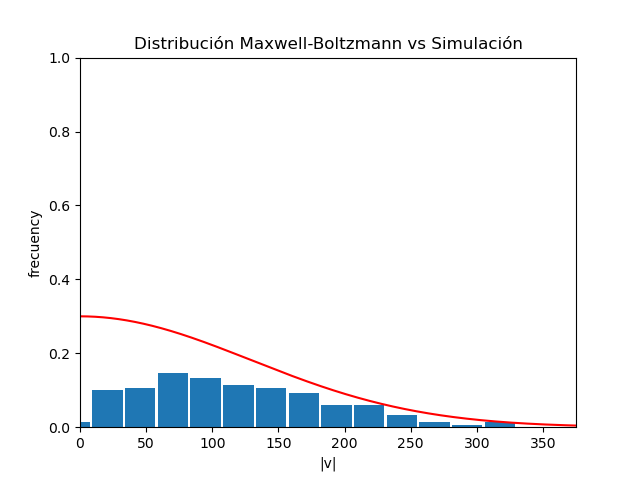

In [154]:
#Esto deja la animación en el notebook
%matplotlib notebook  
import matplotlib.animation as animation
fig = plt.figure()
def update_hist(i):        ##Para usar FuncAnimation hay que tener una función que diga en cada frame cuales son los parametros
                           ##de lo que se va a poner en el frame. Lo único que hice fue 
    plt.cla() #Esto limpia el canvas antes de poner el frame, de lo contrario se amontonan
    plt.plot(u,MBdistribution, color = 'red') #Se pone la distribución
    plt.xlim(0,375)
    plt.ylim(0,1)                     
    plt.ylabel('frecuency')                
    plt.xlabel('|v|')
    #########################################
    res = scipy.stats.relfreq(lista_cuadrados_velocidades[i], numbins=14)
    x = res.lowerlimit + np.linspace(0, res.binsize*res.frequency.size,res.frequency.size)
    ax = fig.add_subplot(1, 1, 1)         #############Todo este código lo saqué de la documentación
    ax.bar(x, res.frequency, width=res.binsize)
    ax.set_title('Distribución Maxwell-Boltzmann vs Simulación')
    ##################################
                                        #Llama la función   #hace 10000 porque hay 10000 pasos, este es el número de frames
animation = animation.FuncAnimation(fig, update_hist,10000)
plt.show()